In [107]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [108]:
!curl -L  https://app.roboflow.com/ds/HR3ZsjTiwY?key=gea06Y4meg > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

%cd /content/
%mkdir images/
%mv train images/train
%mv valid images/valid

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   894  100   894    0     0   2092      0 --:--:-- --:--:-- --:--:--  2088
100 39.1M  100 39.1M    0     0  16.9M      0  0:00:02  0:00:02 --:--:-- 40.1M
Archive:  roboflow.zip
replace README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace README.roboflow.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
   creating: train/
   creating: train/AviÃ£o/
 extracting: train/AviÃ£o/A10_jpg.rf.7b63356f4568228bb41a17fc8e448d69.jpg  
 extracting: train/AviÃ£o/A10_jpg.rf.b2d6117632abec2db35bb55e174b5c27.jpg  
 extracting: train/AviÃ£o/A10_jpg.rf.d9ec6c8c253a32a4a26680a3190ecc48.jpg  
 extracting: train/AviÃ£o/A13_jpg.rf.54fd767fd822e5e33778f1d641ee8f78.jpg  
 extracting: train/AviÃ£o/A13_jpg.rf.6d58a063fcd74de5f93d33fc11b1f4ae.jpg  
 extracting: train/AviÃ£o/A13_jpg.rf.bada0f6d428890449970ce9671f708a6.jpg  
 extracting: train/Av

In [109]:
import tensorflow_datasets as tfds
builder = tfds.folder_dataset.ImageFolder('images/')
print(builder.info)
raw_train = builder.as_dataset(split='train', shuffle_files=True)
raw_valid = builder.as_dataset(split='valid', shuffle_files=True)

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_dir='/root/tensorflow_datasets/image_folder/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=7),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=642, num_shards=1>,
        'valid': <SplitInfo num_examples=92, num_shards=1>,
    },
    citation="""""",
)


In [110]:
IMG_SIZE = 640

def format_example(pair):
  image, label = pair['image'], pair['label']
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [111]:
train = raw_train.map(format_example)
validation = raw_valid.map(format_example)

In [112]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [113]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)

In [114]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 640, 640, 3])

In [115]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)


base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [116]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 20, 20, 1280)


In [117]:
base_model.trainable = False

In [118]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 640, 640, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 320, 320, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 320, 320, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 320, 320, 32)         0         ['bn_Conv1[

In [119]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [120]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [121]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [122]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [123]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 20, 20, 1280)      2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [124]:
len(model.trainable_variables)

2

In [125]:
initial_epochs = 830
validation_steps=830

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

  3/830 [..............................] - ETA: 1:33 - loss: 0.4465 - accuracy: 0.2283

830/830 [==============================] - 2s 356us/step - loss: 0.4465 - accuracy: 0.2283


In [126]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.45
initial accuracy: 0.23


In [127]:
# Weights & Biases
%pip install -q wandb
import wandb

In [128]:
import sys

def wandb_colab_login():
  """Temporary hack to prevent colab from hanging"""
  sys.modules["google.colab2"] = sys.modules["google.colab"]
  del sys.modules["google.colab"]
  wandb.login()
  sys.modules["google.colab"] = sys.modules["google.colab2"]
wandb_colab_login()

In [129]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches,
                    callbacks=[cp_callback])

Epoch 1/830
20/21 [===========================>..] - ETA: 0s - loss: 0.0269 - accuracy: 0.2531
Epoch 1: saving model to training_1/cp.ckpt
21/21 [==============================] - 8s 168ms/step - loss: 0.0269 - accuracy: 0.2523 - val_loss: -0.2259 - val_accuracy: 0.2500
Epoch 2/830
20/21 [===========================>..] - ETA: 0s - loss: -0.4428 - accuracy: 0.2547
Epoch 2: saving model to training_1/cp.ckpt
21/21 [==============================] - 5s 169ms/step - loss: -0.4434 - accuracy: 0.2555 - val_loss: -0.5876 - val_accuracy: 0.2609
Epoch 3/830
20/21 [===========================>..] - ETA: 0s - loss: -0.8211 - accuracy: 0.2609
Epoch 3: saving model to training_1/cp.ckpt
21/21 [==============================] - 4s 170ms/step - loss: -0.8144 - accuracy: 0.2617 - val_loss: -0.8806 - val_accuracy: 0.2609
Epoch 4/830
20/21 [===========================>..] - ETA: 0s - loss: -1.1331 - accuracy: 0.2625
Epoch 4: saving model to training_1/cp.ckpt
21/21 [==============================] - 5s

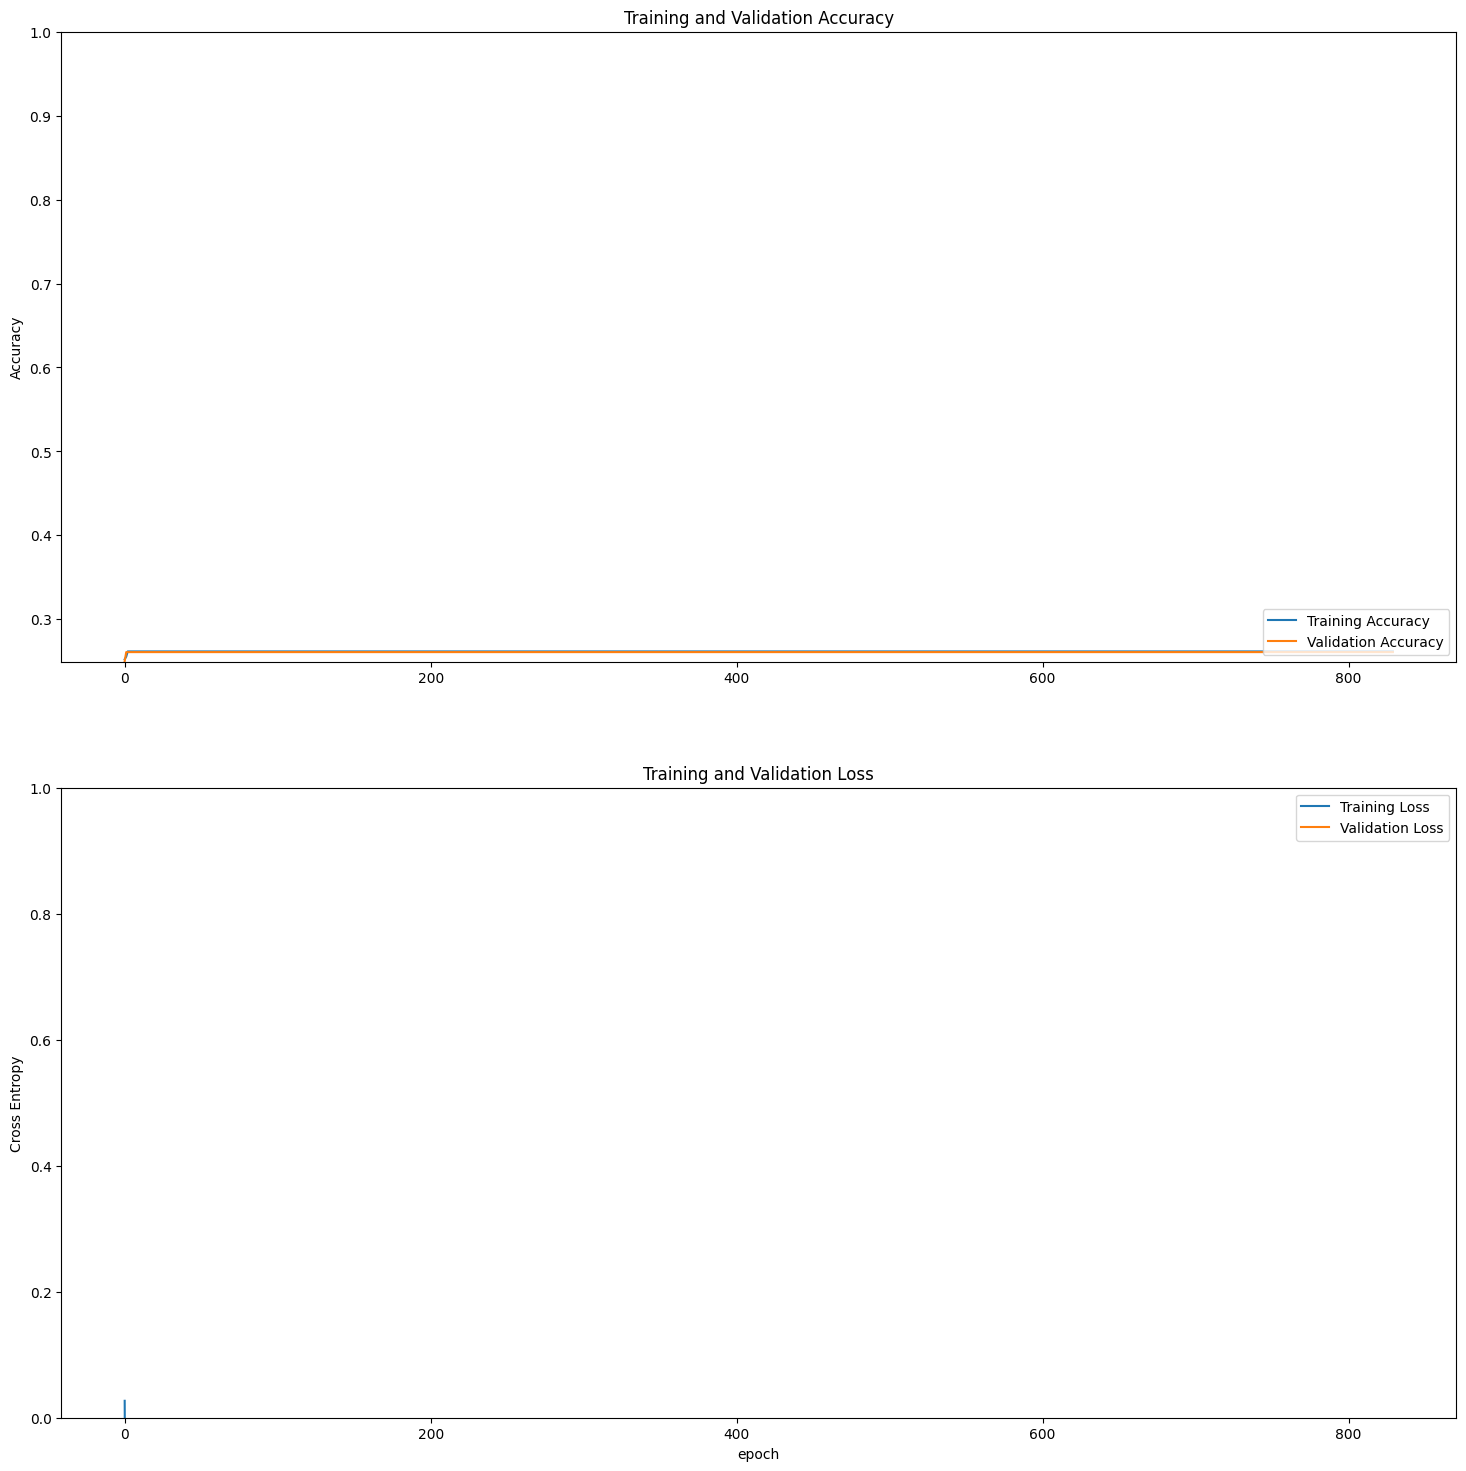

In [130]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(18, 18))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [131]:
!pip install pyyaml h5py

In [132]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.14.0


In [133]:
!mkdir -p saved_model
model.save('saved_model/my_model')

In [134]:
# my_model directory
%ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
%ls saved_model/my_model

my_model/
assets/  fingerprint.pb  keras_metadata.pb  saved_model.pb  variables/


In [135]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 20, 20, 1280)      2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [136]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [137]:
!mkdir /content/drive/MyDrive/Meiosdetransportes/model

mkdir: cannot create directory ‘/content/drive/MyDrive/Meiosdetransportes/model’: File exists


In [138]:
!cp -r saved_model /content/drive/MyDrive/Meiosdetransportes/model

In [139]:
!zip -r modelo.zip saved_model/my_model/

updating: saved_model/my_model/ (stored 0%)
updating: saved_model/my_model/keras_metadata.pb (deflated 96%)
updating: saved_model/my_model/fingerprint.pb (stored 0%)
updating: saved_model/my_model/variables/ (stored 0%)
updating: saved_model/my_model/variables/variables.index (deflated 76%)
updating: saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 8%)
updating: saved_model/my_model/assets/ (stored 0%)
updating: saved_model/my_model/saved_model.pb (deflated 91%)


In [140]:
!mkdir /content/drive/MyDrive/Meiosdetransportes/model/weights

mkdir: cannot create directory ‘/content/drive/MyDrive/Meiosdetransportes/model/weights’: File exists


In [141]:
!cp -r /content/training_1 /content/drive/MyDrive/Meiosdetransportes/model/weights

In [142]:
!zip -r weights.zip /content/training_1

updating: content/training_1/ (stored 0%)
updating: content/training_1/cp.ckpt.index (deflated 78%)
updating: content/training_1/checkpoint (deflated 38%)
updating: content/training_1/cp.ckpt.data-00000-of-00001 (deflated 7%)


In [143]:
base_model.trainable = True

In [144]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [145]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [146]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 20, 20, 1280)      2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1862721 (7.11 MB)
Non-trainable params: 396544 (1.51 MB)
_________________________________________________________________


In [147]:
len(model.trainable_variables)

56

In [148]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 830/930
21/21 [==============================] - 12s 221ms/step - loss: -360.1625 - accuracy: 0.2617 - val_loss: -200.6917 - val_accuracy: 0.2609
Epoch 831/930
21/21 [==============================] - 4s 179ms/step - loss: -411.2680 - accuracy: 0.2617 - val_loss: -197.3088 - val_accuracy: 0.2609
Epoch 832/930
21/21 [==============================] - 5s 182ms/step - loss: -457.1402 - accuracy: 0.2617 - val_loss: -189.8385 - val_accuracy: 0.2609
Epoch 833/930
21/21 [==============================] - 4s 180ms/step - loss: -500.3221 - accuracy: 0.2617 - val_loss: -183.2904 - val_accuracy: 0.2609
Epoch 834/930
21/21 [==============================] - 4s 181ms/step - loss: -558.0883 - accuracy: 0.2617 - val_loss: -172.7488 - val_accuracy: 0.2609
Epoch 835/930
21/21 [==============================] - 4s 180ms/step - loss: -617.8730 - accuracy: 0.2617 - val_loss: -164.1339 - val_accuracy: 0.2609
Epoch 836/930
21/21 [==============================] - 4s 181ms/step - loss: -675.4917 - accu

In [149]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

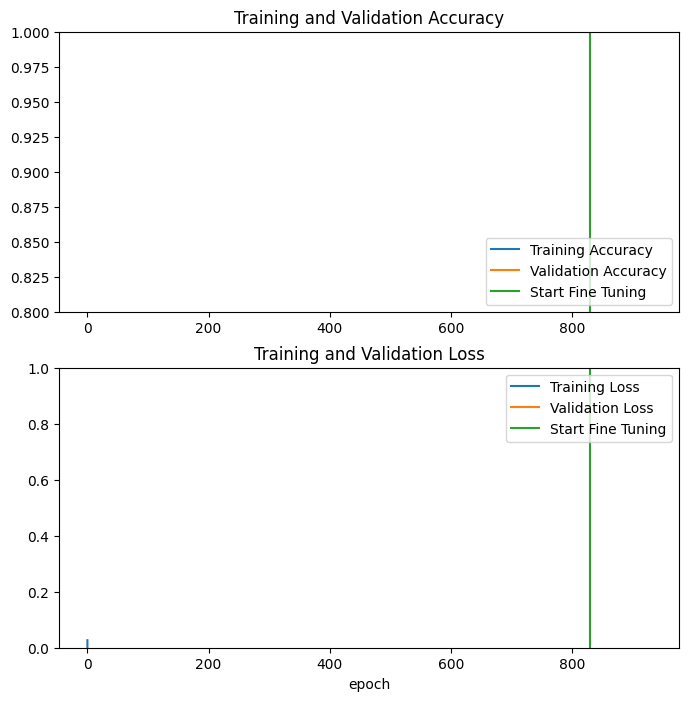

In [150]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()